<center><h1>Wang_Timothy_finalproject</h1></center>

Name: Timothy Wang
<br>
Github Username: timothyswang
<br>
USC ID: 2697040790

## 1. Transfer Learning for Image Classification

Import packages

In [256]:
import os
import pandas as pd
import numpy as np
import seaborn
import sklearn.svm as svm
import sklearn.metrics as metrics
import sklearn.cluster as cluster
from statistics import mode
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE

from tensorflow import keras
import cv2 as cv
import splitfolders
from tensorflow.keras.applications import EfficientNetB0
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16

### (a)

### (b) Data Exploration and Pre-processing

#### Resize All Images to the Same Size

In [13]:
#[1]
outer_path = "../data/images/"
outer_path_list = os.listdir(outer_path)

output_path = "../data/res_images/"

for this_bird_dir in outer_path_list:
    inner_path = outer_path + this_bird_dir

    inner_path_list = os.listdir(inner_path)

    new_output_path = output_path + this_bird_dir

    for this_bird_path in inner_path_list:
        # print(inner_path + this_bird_path)
        # break
        #[2]
        this_img = cv.imread(inner_path + "/" + this_bird_path)
        resized_img = cv.resize(this_img, (300, 300))

        #[3]
        cv.imwrite(new_output_path + "/" + this_bird_path, resized_img)

#### Get All Images and Split into Train, Val, and Test Sets

In [17]:
#[4]
splitfolders.ratio(output_path, output="../data/split_images/", seed=101, ratio=(0.7,0.15,0.15))

In [227]:
#[5] label_mode = categorical --> one hot encoding
#[6] [7] Efficient Net B0 and VGG16 has default size (224, 224)
train_set = keras.utils.image_dataset_from_directory("../data/split_images/train", label_mode="categorical", image_size=(224, 224))
val_set = keras.utils.image_dataset_from_directory("../data/split_images/val", label_mode="categorical", image_size=(224, 224))
test_set = keras.utils.image_dataset_from_directory("../data/split_images/test", label_mode="categorical", image_size=(224, 224))

print(train_set)
print(val_set)
print(test_set)

Found 820 files belonging to 20 classes.


Found 171 files belonging to 20 classes.
Found 185 files belonging to 20 classes.
<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None))>


### (c) Transfer Learning

#### Empirical Regularization on Train Images (Perform Transformations on the Training Images)

In [63]:
def img_scaling(input_path, output_path, old_output_path):
    #[2]
    this_img = cv.imread(input_path)
    new_img = cv.resize(this_img, None, fx=2.0, fy=2.0)
    #[3]
    cv.imwrite(output_path, new_img)
    cv.imwrite(old_output_path, this_img)

def img_translation(input_path, output_path, old_output_path):
    #[2]
    this_img = cv.imread(input_path)
    dim_row, dim_col = this_img.shape[:2]
    this_matrix = np.float32([[1,0,50],[0,1,50]])
    new_img = cv.warpAffine(this_img,this_matrix,(dim_col,dim_row))
    #[3]
    cv.imwrite(output_path, new_img)
    cv.imwrite(old_output_path, this_img)

def img_contrast(input_path, output_path, old_output_path):
    #[2]
    this_img = cv.imread(input_path)
    #[8]
    new_img = cv.convertScaleAbs(this_img, alpha=1.5, beta=0)
    #[3]
    cv.imwrite(output_path, new_img)
    cv.imwrite(old_output_path, this_img)

def img_flip(input_path, output_path, old_output_path):
    #[2]
    this_img = cv.imread(input_path)
    #[9]
    new_img = cv.flip(this_img, 0)
    #[3]
    cv.imwrite(output_path, new_img)
    cv.imwrite(old_output_path, this_img)

def img_crop(input_path, output_path, old_output_path):
    #[2]
    this_img = cv.imread(input_path)
    dim_row, dim_col = this_img.shape[:2]
    #[10]
    new_img = this_img[40:dim_row-40, 40:dim_col-40]
    #[3]
    cv.imwrite(output_path, new_img)
    cv.imwrite(old_output_path, this_img)


#[1]
original_path = "../data/split_images/train/"
original_path_list = os.listdir(original_path)
print(original_path_list)

for this_directory in original_path_list:
    input_path = "../data/split_images/train/" + this_directory
    output_path = "../data/train_transformed/" + this_directory

    #[1]
    input_path_list = os.listdir(input_path)

    for i in range(len(input_path_list)):

        new_input_path = input_path + "/" + input_path_list[i]
        new_output_path = output_path + "/" + "two" + input_path_list[i]

        old_output_path = output_path + "/" + input_path_list[i]

        print(new_input_path)
        print(new_output_path)

        transformation_index = i % 5

        if transformation_index == 0:
            img_scaling(new_input_path, new_output_path, old_output_path)
        if transformation_index == 1:
            img_translation(new_input_path, new_output_path, old_output_path)
        if transformation_index == 2:
            img_contrast(new_input_path, new_output_path, old_output_path)
        if transformation_index == 3:
            img_flip(new_input_path, new_output_path, old_output_path)
        if transformation_index == 4:
            img_crop(new_input_path, new_output_path, old_output_path)

['005.Crested_Auklet', '015.Lazuli_Bunting', '156.White_eyed_Vireo', '081.Pied_Kingfisher', '135.Bank_Swallow', '086.Pacific_Loon', '067.Anna_Hummingbird', '076.Dark_eyed_Junco', '149.Brown_Thrasher', '127.Savannah_Sparrow', '041.Scissor_tailed_Flycatcher', '141.Artic_Tern', '082.Ringed_Kingfisher', '099.Ovenbird', '013.Bobolink', '104.American_Pipit', '023.Brandt_Cormorant', '168.Kentucky_Warbler', '072.Pomarine_Jaeger', '040.Olive_sided_Flycatcher']
../data/split_images/train/005.Crested_Auklet/Crested_Auklet_0001_794941.jpg
../data/train_transformed/005.Crested_Auklet/twoCrested_Auklet_0001_794941.jpg
../data/split_images/train/005.Crested_Auklet/Crested_Auklet_0074_794949.jpg
../data/train_transformed/005.Crested_Auklet/twoCrested_Auklet_0074_794949.jpg
../data/split_images/train/005.Crested_Auklet/Crested_Auklet_0077_785257.jpg
../data/train_transformed/005.Crested_Auklet/twoCrested_Auklet_0077_785257.jpg
../data/split_images/train/005.Crested_Auklet/Crested_Auklet_0018_1817.jpg
.

Recreate train_set

In [251]:
#[5] Old training photos AND newly transformed photos (see above cell)
train_set = keras.utils.image_dataset_from_directory("../data/train_transformed", label_mode="categorical", image_size=(224, 224))
print(train_set)

Found 1640 files belonging to 20 classes.
<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None))>


#### Efficient Net B0

In [252]:
#[11] Set up what input will look like
model_inputs = layers.Input(shape=(224, 224, 3))

#[11]
# Remove last layer and have the default dropout rate of 20%
enb_init_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=model_inputs)
#[11] freeze all previous layers
enb_init_model.trainable = False

#[11] Add layers -- Batch normalization, dropout layer with dropout rate of 20%, and a ReLU and softmax activation layer at the end.
#[12]
new_layers = layers.BatchNormalization(name="batch_normalization_layer")(enb_init_model.output) #[13]
new_layers = layers.Dropout(0.2, name="dropout_layer")(new_layers) #[14]
new_layers = layers.ReLU(name="ReLU_layer")(new_layers) #[15]
new_layers = layers.Dense((20), activation="softmax", name="dense_layer")(new_layers) #[16]
model_outputs = layers.GlobalAveragePooling2D(keepdims=False)(new_layers) #[22] Make output tensor shape match the output tensor shape of the train/val/test data.
print(model_outputs)

#[11] 
enb_fin_model = keras.Model(model_inputs, model_outputs)

#[11] [17] [18] ADAM optimizer [19] Categorical_CrossEntropy [25] Compile model with ADAM optimizer and have a categorical cross entropy loss
#[26] Metrics will include Mean Absolute Error (for the graph), Precision, Recall, and F1 Score
enb_fin_model.compile(optimizer="ADAM", loss="categorical_crossentropy", metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()])

enb_fin_model.summary() #[23]

KerasTensor(type_spec=TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), name='global_average_pooling2d_5/Mean:0', description="created by layer 'global_average_pooling2d_5'")
Model: "model_45"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_65 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_126 (Rescaling)   (None, 224, 224, 3)          0         ['input_65[0][0]']            
                                                                                                  
 normalization_63 (Normaliz  (None, 224, 224, 3)          7         ['rescaling_126[0][0]']       
 ation)                                                                                           
      

In [253]:
#[20]
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=4)

print(enb_fin_model.input)

#[20][21] Set batch size to 5
enb_results = enb_fin_model.fit(x=train_set, batch_size=5, epochs=100, callbacks=[early_stopping_callback], validation_data=val_set)

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_65'), name='input_65', description="created by layer 'input_65'")
Epoch 1/100


52/52 [==============================] - 17s 272ms/step - loss: 2.3995 - mean_absolute_error: 0.0892 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.4282 - val_loss: 1.9249 - val_mean_absolute_error: 0.0840 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.6849
Epoch 2/100
52/52 [==============================] - 13s 245ms/step - loss: 1.6790 - mean_absolute_error: 0.0794 - precision: 1.0000 - recall: 0.0049 - f1_score: 0.7854 - val_loss: 1.6501 - val_mean_absolute_error: 0.0789 - val_precision: 1.0000 - val_recall: 0.0058 - val_f1_score: 0.7448
Epoch 3/100
52/52 [==============================] - 13s 250ms/step - loss: 1.4714 - mean_absolute_error: 0.0749 - precision: 0.9333 - recall: 0.0256 - f1_score: 0.8365 - val_loss: 1.5200 - val_mean_absolute_error: 0.0757 - val_precision: 0.7143 - val_recall: 0.0292 - val_f1_score: 0.7728
Epoch 4/100
52/52 [==============================] - 13s 249ms/step - loss: 1.3458 - mean_absolute_error: 0.0715 - precision: 

### EfficientNetB0 Error Graph

dict_keys(['loss', 'mean_absolute_error', 'precision', 'recall', 'f1_score', 'val_loss', 'val_mean_absolute_error', 'val_precision', 'val_recall', 'val_f1_score'])


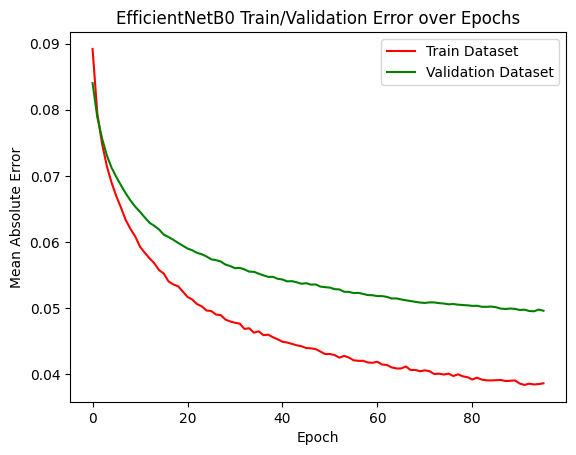

In [254]:
#[24]
print(enb_results.history.keys())
plt.plot(enb_results.history['mean_absolute_error'], color="red")
plt.plot(enb_results.history['val_mean_absolute_error'], color="green")

#Extra stuff to make the graph more presentable
plt.title('EfficientNetB0 Train/Validation Error over Epochs')
plt.legend(['Train Dataset', 'Validation Dataset'], loc='upper right')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.show()

#### EfficientNetB0 Report Precision, Recall, and F1 score

In [255]:
#[27]
enb_evaluation = enb_fin_model.evaluate(x=test_set)

print(enb_evaluation)

6/6 [==============================] - 1s 208ms/step - loss: 0.7595 - mean_absolute_error: 0.0455 - precision: 0.9417 - recall: 0.5243 - f1_score: 0.8183
[0.7595076560974121, 0.04554884508252144, 0.9417475461959839, 0.5243242979049683, array([0.93333334, 0.90000004, 0.84210527, 0.9       , 0.72727275,
       0.7058823 , 0.94117653, 0.90000004, 0.9473684 , 0.8       ,
       0.875     , 0.84210527, 0.8       , 0.7       , 0.8       ,
       0.42857146, 0.9473684 , 0.7       , 0.8181818 , 0.8571428 ],
      dtype=float32)]


According to the evaluation, it appears that the precision for this model is 0.9417, the recall for this model is 0.5243, and the f1 score for this model is 0.8183.

#### VGG16 Model

In [257]:
#[11] Set up what input will look like
model_inputs = layers.Input(shape=(224, 224, 3))

#[28]
vgg_init_model = VGG16(include_top=False, weights='imagenet', input_tensor=model_inputs)
#[11] freeze all previous layers
vgg_init_model.trainable = False

#[11] Add layers -- Batch normalization, dropout layer with dropout rate of 20%, and a ReLU and softmax activation layer at the end.
#[12]
new_layers = layers.BatchNormalization(name="batch_normalization_layer")(vgg_init_model.output) #[13]
new_layers = layers.Dropout(0.2, name="dropout_layer")(new_layers) #[14]
new_layers = layers.ReLU(name="ReLU_layer")(new_layers) #[15]
new_layers = layers.Dense((20), activation="softmax", name="dense_layer")(new_layers) #[16]
model_outputs = layers.GlobalAveragePooling2D(keepdims=False)(new_layers) #[22] Make output tensor shape match the output tensor shape of the train/val/test data.
print(model_outputs)

#[11] 
vgg_fin_model = keras.Model(model_inputs, model_outputs)

#[11] [17] [18] ADAM Optimizer [19] Categorical_CrossEntropy [25] Compile model with ADAM optimizer and have a categorical cross entropy loss
#[26] Metrics will include Mean Absolute Error (for the graph), Precision, Recall, and F1 Score
vgg_fin_model.compile(optimizer="ADAM", loss="categorical_crossentropy", metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()])

vgg_fin_model.summary() #[23]

58889256/58889256 [==============================] - 4s 0us/step
KerasTensor(type_spec=TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), name='global_average_pooling2d_6/Mean:0', description="created by layer 'global_average_pooling2d_6'")
Model: "model_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_66 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
       

In [258]:
#[20]
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=4)

print(vgg_fin_model.input)

#[20][21] Set batch size to 5
vgg_results = vgg_fin_model.fit(x=train_set, batch_size=5, epochs=100, callbacks=[early_stopping_callback], validation_data=val_set)

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_66'), name='input_66', description="created by layer 'input_66'")
Epoch 1/100
52/52 [==============================] - 110s 2s/step - loss: 2.8275 - mean_absolute_error: 0.0935 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score: 0.1390 - val_loss: 2.4799 - val_mean_absolute_error: 0.0902 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.2309
Epoch 2/100
52/52 [==============================] - 104s 2s/step - loss: 2.3651 - mean_absolute_error: 0.0896 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score: 0.4291 - val_loss: 2.2074 - val_mean_absolute_error: 0.0872 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.3626
Epoch 3/100
52/52 [==============================] - 105s 2s/step - loss: 2.1029 - mean_absolute_error: 0.0864 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score: 0.5976 - val_loss: 2.0555 - val_mean_absolute_er

dict_keys(['loss', 'mean_absolute_error', 'precision_1', 'recall_1', 'f1_score', 'val_loss', 'val_mean_absolute_error', 'val_precision_1', 'val_recall_1', 'val_f1_score'])


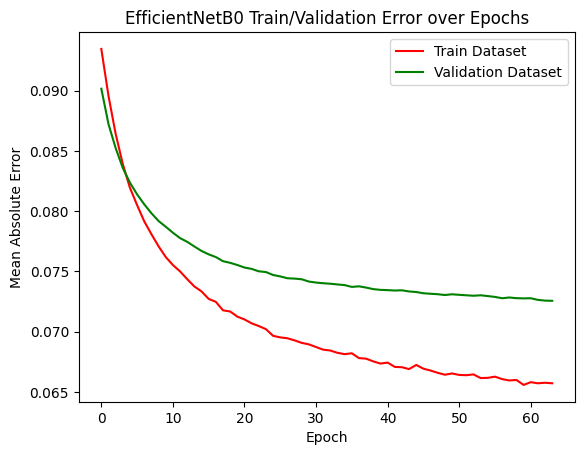

In [259]:
#[24]
print(vgg_results.history.keys())
plt.plot(vgg_results.history['mean_absolute_error'], color="red")
plt.plot(vgg_results.history['val_mean_absolute_error'], color="green")

#Extra stuff to make the graph more presentable
plt.title('EfficientNetB0 Train/Validation Error over Epochs')
plt.legend(['Train Dataset', 'Validation Dataset'], loc='upper right')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.show()

In [260]:
#[27]
vgg_evaluation = vgg_fin_model.evaluate(x=test_set)

print(vgg_evaluation)

6/6 [==============================] - 11s 2s/step - loss: 1.4241 - mean_absolute_error: 0.0706 - precision_1: 0.9583 - recall_1: 0.1243 - f1_score: 0.6566
[1.4241148233413696, 0.07063951343297958, 0.9583333134651184, 0.12432432174682617, array([0.85714287, 0.5925926 , 0.5882353 , 0.73684216, 0.8235294 ,
       0.8       , 0.73684216, 0.75      , 0.5       , 0.57142854,
       0.5       , 0.7619048 , 0.57142854, 0.5       , 0.75      ,
       0.42105263, 0.9       , 0.5882353 , 0.54545456, 0.6363636 ],
      dtype=float32)]


According to the evaluation, it appears that the precision for this model is 0.9583, the recall for this model is 0.1243, and the f1 score for this model is 0.6566.

References:

[1] https://www.geeksforgeeks.org/python-list-files-in-a-directory/

[2] https://docs.opencv.org/4.x/da/d6e/tutorial_py_geometric_transformations.html

[3] https://www.geeksforgeeks.org/resize-multiple-images-using-opencv-python/#

[4] https://pypi.org/project/split-folders/

[5] https://keras.io/api/data_loading/image/#imagedatasetfromdirectory-function

[6] https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

[7] https://keras.io/api/applications/vgg/

[8] https://www.tutorialspoint.com/how-to-change-the-contrast-and-brightness-of-an-image-using-opencv-in-python

[9] https://www.geeksforgeeks.org/python-opencv-cv2-flip-method/#

[10] https://learnopencv.com/cropping-an-image-using-opencv/

[11] https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/#transfer-learning-from-pretrained-weights

[12] https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer

[13] https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization

[14] https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout

[15] https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU

[16] https://keras.io/api/layers/core_layers/dense/

[17] https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile

[18] https://keras.io/api/optimizers/adam/

[19] https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy

[20] https://keras.io/api/callbacks/early_stopping/

[21] https://keras.io/api/models/model_training_apis/#fit-method

[22] https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D

[23] https://keras.io/api/models/model/#summary-method

[24] https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

[25] https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanAbsoluteError

[26] https://www.tensorflow.org/api_docs/python/tf/keras/metrics

[27] https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate

[28] https://keras.io/api/applications/vgg/#vgg16-function